In [253]:
import os
import numpy as np
import pandas as pd

import rasterio

from pathlib import Path
from pandas_path import path

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [7]:
PATH_TO_DATA = './data/'
os.listdir(PATH_TO_DATA)

['flood-training-metadata.csv', 'train_features', 'train_labels']

In [17]:
train_metadata = pd.read_csv(
    os.path.join(PATH_TO_DATA, 'flood-training-metadata.csv'),
    parse_dates=["scene_start"]
)
train_metadata.shape

(1084, 6)

In [18]:
train_metadata.head()

,image_id,chip_id,flood_id,polarization,location,scene_start
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15


In [19]:
train_metadata['scene_start'][0]

Timestamp('2018-02-15 00:00:00')

In [31]:
flood_counts = train_metadata.groupby("flood_id")["chip_id"].nunique()

In [33]:
flood_counts

flood_id
awc    15
ayt    18
coz    28
hbe    69
hxu    26
jja    66
kuo    65
pxs    68
qus    30
qxb    42
tht    30
tnp    53
wvy    32
Name: chip_id, dtype: int64

In [32]:
flood_counts.describe()

count    13.000000
mean     41.692308
std      19.947367
min      15.000000
25%      28.000000
50%      32.000000
75%      65.000000
max      69.000000
Name: chip_id, dtype: float64

In [72]:
DATA_PATH = Path("./data/")

In [73]:
DATA_PATH / "train_features"

PosixPath('data/train_features')

In [74]:
train_metadata["feature_path"] = (
    str(DATA_PATH / "train_features")
    / train_metadata.image_id.path.with_suffix(".tif").path
)

In [75]:
train_metadata["label_path"] = (
    str(DATA_PATH / "train_labels")
    / train_metadata.chip_id.path.with_suffix(".tif").path
)

In [76]:
train_metadata.head()

,image_id,chip_id,flood_id,polarization,location,scene_start,feature_path,label_path
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15,data/train_features/awc00_vh.tif,data/train_labels/awc00.tif
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15,data/train_features/awc00_vv.tif,data/train_labels/awc00.tif
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15,data/train_features/awc01_vh.tif,data/train_labels/awc01.tif
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15,data/train_features/awc01_vv.tif,data/train_labels/awc01.tif
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15,data/train_features/awc02_vh.tif,data/train_labels/awc02.tif


# Read images

In [37]:
os.listdir(PATH_TO_DATA)

['flood-training-metadata.csv', 'train_features', 'train_labels']

In [46]:
feature_path = os.path.join(PATH_TO_DATA, 'train_features')
label_path = os.path.join(PATH_TO_DATA, 'train_labels')

In [230]:
image_id = train_metadata['image_id'][0] # 0, 13
image_id = f'{image_id}.tif'
image_path = os.path.join(feature_path, image_id)

In [231]:
with rasterio.open(image_path) as img:
    metadata = img.meta
    bounds = img.bounds
    data = img.read(1)

In [232]:
metadata

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 0.0,
 'width': 512,
 'height': 512,
 'count': 1,
 'crs': CRS.from_epsg(32720),
 'transform': Affine(10.0, 0.0, 314030.0,
        0.0, -10.0, 8585890.0)}

In [233]:
bounds

BoundingBox(left=314030.0, bottom=8580770.0, right=319150.0, top=8585890.0)

In [234]:
data.shape

(512, 512)

In [228]:
def show_image(image, cmap=None):
    # plt.figure(figsize=(5,5))
    plt.grid(False)
    plt.axis('off')
#     plt.imshow(image)
#     plt.imshow(image, cmap='bone') # gray, bone
    plt.imshow(image, cmap=cmap)
    plt.show()

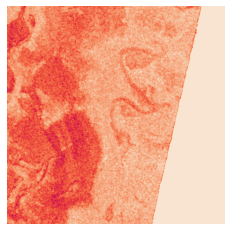

In [229]:
show_image(data)

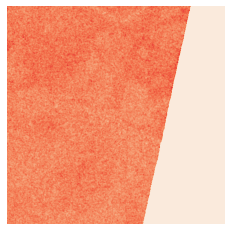

In [235]:
show_image(data)

In [59]:
with rasterio.open(image_path) as img:
    gdal_mask = img.dataset_mask()

In [60]:
gdal_mask

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

In [61]:
with rasterio.open(image_path) as img:
    numpy_mask = img.read(1, masked=True)

In [62]:
numpy_mask

masked_array(
  data=[[-16.20801544189453, -17.71950912475586, -16.281352996826172,
         ..., --, --, --],
        [-15.328896522521973, -18.231857299804688, -16.451892852783203,
         ..., --, --, --],
        [-15.353134155273438, -16.888309478759766, -15.585904121398926,
         ..., --, --, --],
        ...,
        [-15.74166202545166, -15.230668067932129, -13.455254554748535,
         ..., --, --, --],
        [-15.498257637023926, -14.100983619689941, -13.110269546508789,
         ..., --, --, --],
        [-16.05560302734375, -14.112099647521973, -14.76084041595459,
         ..., --, --, --]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=0.0,
  dtype=f

# Read label

In [157]:
label_path = train_metadata.label_path[13]
label_path

'data/train_labels/awc06.tif'

In [159]:
with rasterio.open(label_path) as lp:
    lp_img = lp.read(1)

In [160]:
lp_img

array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8)

In [166]:
np.unique(lp_img)

array([  0,   1, 255], dtype=uint8)

In [171]:
label = np.ma.masked_where((lp_img == 0) | (lp_img == 255), lp_img)

In [175]:
label

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=999999,
  dtype=uint8)

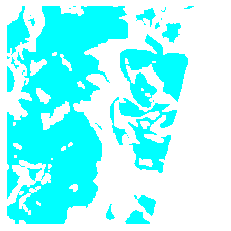

In [174]:
show_image(label, cmap='cool')

# Show images

In [92]:
# Helper functions for visualizing Sentinel-1 images
def scale_img(matrix):
    """
    Returns a scaled (H, W, D) image that is visually inspectable.
    Image is linearly scaled between min_ and max_value, by channel.

    Args:
        matrix (np.array): (H, W, D) image to be scaled

    Returns:
        np.array: Image (H, W, 3) ready for visualization
    """
    # Set min/max values
    min_values = np.array([-23, -28, 0.2])
    max_values = np.array([0, -5, 1])

    # Reshape matrix
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)

    # Scale by min/max
    matrix = (matrix - min_values[None, :]) / (
        max_values[None, :] - min_values[None, :]
    )
    matrix = np.reshape(matrix, [w, h, d])

    # Limit values to 0/1 interval
    return matrix.clip(0, 1)


def create_false_color_composite(path_vv, path_vh):
    """
    Returns a S1 false color composite for visualization.

    Args:
        path_vv (str): path to the VV band
        path_vh (str): path to the VH band

    Returns:
        np.array: image (H, W, 3) ready for visualization
    """
    # Read VV/VH bands
    with rasterio.open(path_vv) as vv:
        vv_img = vv.read(1)
    with rasterio.open(path_vh) as vh:
        vh_img = vh.read(1)

    # Stack arrays along the last dimension
    s1_img = np.stack((vv_img, vh_img), axis=-1)

    # Create false color composite
    img = np.zeros((512, 512, 3), dtype=np.float32)
    img[:, :, :2] = s1_img.copy()
    img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]

    return scale_img(img)


def display_random_chip(random_state):
    """
    Plots a 3-channel representation of VV/VH polarizations as a single chip (image 1).
    Overlays a chip's corresponding water label (image 2).

    Args:
        random_state (int): random seed used to select a chip

    Returns:
        plot.show(): chip and labels plotted with pyplot
    """
    f, ax = plt.subplots(1, 2, figsize=(9, 9))

    # Select a random chip from train_metadata
#     random_chip = train_metadata.chip_id.sample(random_state=random_state).values[0]
    random_chip = train_metadata.chip_id.values[random_state]
    chip_df = train_metadata[train_metadata.chip_id == random_chip]

    # Extract paths to image files
    vv_path = chip_df[chip_df.polarization == "vv"].feature_path.values[0]
    vh_path = chip_df[chip_df.polarization == "vh"].feature_path.values[0]
    
    label_path = chip_df.label_path.values[0]

    # Create false color composite
    s1_img = create_false_color_composite(vv_path, vh_path)

    # Visualize features
    ax[0].imshow(s1_img)
    ax[0].set_title("S1 Chip", fontsize=14)
    ax[0].grid(False)

    # Load water mask
    with rasterio.open(label_path) as lp:
        lp_img = lp.read(1)

    # Mask missing data and 0s for visualization
    label = np.ma.masked_where((lp_img == 0) | (lp_img == 255), lp_img)

    # Visualize water label
    ax[1].imshow(s1_img)
    ax[1].imshow(label, cmap="cool", alpha=1)
    ax[1].set_title("S1 Chip with Water Label", fontsize=14)

    ax[1].grid(False)
#     ax[1].axis('off')
    
    plt.tight_layout(pad=5)
    plt.show()

<ipython-input-92-bc7ca5dc04a9>:54: RuntimeWarning: invalid value encountered in true_divide
  img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]


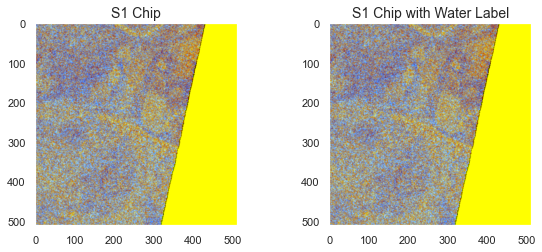

In [105]:
# what use of images without masks?
display_random_chip(0)

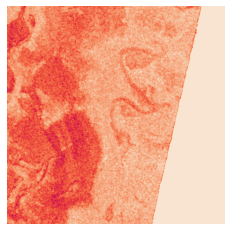

In [209]:
show_image(data)

<ipython-input-92-bc7ca5dc04a9>:54: RuntimeWarning: invalid value encountered in true_divide
  img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]


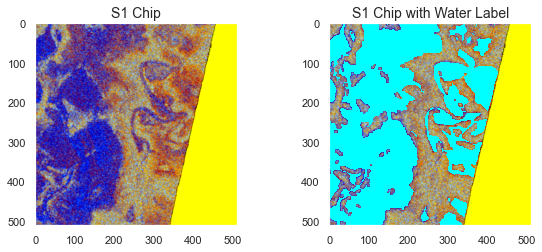

In [95]:
display_random_chip(13)

# Dataset

In [112]:
train_metadata.head()

,image_id,chip_id,flood_id,polarization,location,scene_start,feature_path,label_path
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15,data/train_features/awc00_vh.tif,data/train_labels/awc00.tif
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15,data/train_features/awc00_vv.tif,data/train_labels/awc00.tif
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15,data/train_features/awc01_vh.tif,data/train_labels/awc01.tif
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15,data/train_features/awc01_vv.tif,data/train_labels/awc01.tif
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15,data/train_features/awc02_vh.tif,data/train_labels/awc02.tif


In [109]:
# Helper function for pivoting out paths by chip
def get_paths_by_chip(image_level_df):
    """
    Returns a chip-level dataframe with pivoted columns
    for vv_path and vh_path.

    Args:
        image_level_df (pd.DataFrame): image-level dataframe

    Returns:
        chip_level_df (pd.DataFrame): chip-level dataframe
    """
    paths = []
    for chip, group in image_level_df.groupby("chip_id"):
        vv_path = group[group.polarization == "vv"]["feature_path"].values[0]
        vh_path = group[group.polarization == "vh"]["feature_path"].values[0]
        paths.append([chip, vv_path, vh_path])
    return pd.DataFrame(paths, columns=["chip_id", "vv_path", "vh_path"])

In [110]:
train = train_metadata

In [132]:
train_x = get_paths_by_chip(train)
train_x.head()

,chip_id,vv_path,vh_path
0,awc00,data/train_features/awc00_vv.tif,data/train_features/awc00_vh.tif
1,awc01,data/train_features/awc01_vv.tif,data/train_features/awc01_vh.tif
2,awc02,data/train_features/awc02_vv.tif,data/train_features/awc02_vh.tif
3,awc03,data/train_features/awc03_vv.tif,data/train_features/awc03_vh.tif
4,awc04,data/train_features/awc04_vv.tif,data/train_features/awc04_vh.tif


In [133]:
train_y = train[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)
train_y.head()

,chip_id,label_path
0,awc00,data/train_labels/awc00.tif
1,awc01,data/train_labels/awc01.tif
2,awc02,data/train_labels/awc02.tif
3,awc03,data/train_labels/awc03.tif
4,awc04,data/train_labels/awc04.tif


In [264]:
from dataset import FloodDataset

In [265]:
train_dataset = FloodDataset(train_x, train_y, transforms=None)

In [138]:
len(train_dataset)

542

In [178]:
sample_data = train_dataset[0]

In [180]:
chip = sample_data['chip']
chip.shape

(2, 512, 512)

In [181]:
label = sample_data['label']
label.shape

(512, 512)

In [182]:
np.unique(label)

array([  0, 255], dtype=uint8)

In [190]:
chip[0].shape

(512, 512)

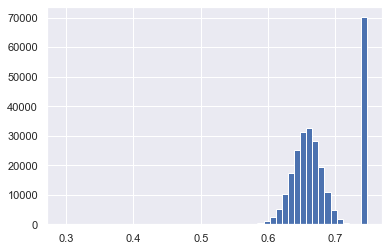

In [195]:
plt.hist(chip[0].reshape(-1), bins=50)
plt.show()

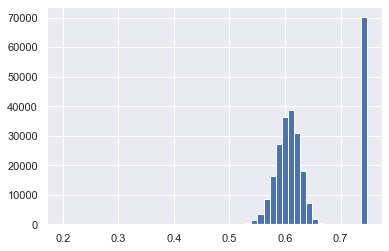

In [196]:
plt.hist(chip[1].reshape(-1), bins=50)
plt.show()

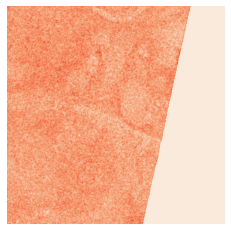

In [197]:
show_image(chip[0])

# Single model path¶

In [199]:
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
#     num_workers=0,
#     pin_memory=True
)

In [200]:
train_loader_iter = iter(train_loader)

In [204]:
data_dict = next(train_loader_iter)

id_batch = data_dict['chip_id']
x_batch = data_dict['chip']
y_batch = data_dict['label']

In [205]:
id_batch

['wvy08', 'kuo21', 'wvy29', 'jja21']

In [207]:
x_batch.shape

torch.Size([4, 2, 512, 512])

In [248]:
y_batch.shape, y_batch.dtype

(torch.Size([4, 512, 512]), torch.uint8)

In [238]:
import segmentation_models_pytorch as smp

In [239]:
encoder_name = 'resnet18'
encoder_weights = 'imagenet'

unet_model = smp.Unet(
    encoder_name=encoder_name,
    encoder_weights=encoder_weights,
    in_channels=2,
    classes=2,
)

In [241]:
# unet_model

In [242]:
output = unet_model(x_batch)

In [243]:
output.shape

torch.Size([4, 2, 512, 512])

In [261]:
loss = nn.CrossEntropyLoss(ignore_index=255)

In [249]:
y_batch = y_batch.type(torch.long)

In [250]:
loss_value = loss(output, y_batch)
loss_value

tensor(0.8681, grad_fn=<NllLoss2DBackward>)

In [292]:
preds = torch.softmax(output, dim=1)[:, 1]
preds.shape

torch.Size([4, 512, 512])

In [296]:
preds = (preds > 0.5) * 1
# preds

In [300]:
correct_pixels = (preds == y_batch).sum()
all_pixels = torch.tensor(preds.size()).prod()

In [303]:
correct_pixels, all_pixels, correct_pixels/all_pixels

(tensor(499494), tensor(1048576), tensor(0.4764))

# Split the dataset

In [266]:
import random

In [267]:
random.seed(9)  # set a seed for reproducibility

# Sample 3 random floods for validation set
flood_ids = train_metadata.flood_id.unique().tolist()
val_flood_ids = random.sample(flood_ids, 3)
val_flood_ids

['pxs', 'qxb', 'jja']

In [271]:
len(flood_ids)

13

In [274]:
val = train_metadata[train_metadata.flood_id.isin(val_flood_ids)]
train = train_metadata[~train_metadata.flood_id.isin(val_flood_ids)]

In [275]:
# Separate features from labels
val_x = get_paths_by_chip(val)
val_y = val[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

train_x = get_paths_by_chip(train)
train_y = train[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

In [278]:
len(val_x) / (len(val_x) + len(train_x)) * 100

32.47232472324723

# Train

In [251]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [307]:
from train import train_model
from utils import get_device

In [284]:
num_valid = 16

val_x = val_x[:16]
val_y = val_y[:16]

In [285]:
train_dataset = FloodDataset(train_x, train_y, transforms=None)
valid_dataset = FloodDataset(val_x, val_y, transforms=None)

In [286]:
len(valid_dataset)

16

In [287]:
batch_size_train = 4
batch_size_valid = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size_valid, shuffle=False)

In [288]:
len(train_loader), len(valid_loader)

(92, 4)

In [255]:
device = get_device()

[device] No GPU available, using the CPU instead.


In [256]:
learning_rate=3e-4
weight_decay=0

optimizer = torch.optim.Adam(
    unet_model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)

In [308]:
train_info = train_model(
    model=unet_model,
    device=device,
    data_loader=train_loader,
    valid_loader=valid_loader,
    criterion=loss,
    optimizer=optimizer,
    max_iter=4,
    valid_iters=[2,3],
    verbose=True,
    print_every=2
)

[train] started...
[train] iter:    0, loss = 0.45895, score = 0.00000, time: 0:00:19
[train] iter:    2, loss = 0.39573, score = 0.00000, time: 0:00:57
[train] iter:    2, loss = 0.39573, score = 0.00000, time: 0:01:15
[valid] iter:    2, loss = 0.50802, score = 0.09823, time: 0:01:15

[train] iter:    3, loss = 0.39071, score = 0.00000, time: 0:01:53
[valid] iter:    3, loss = 0.50817, score = 0.11416, time: 0:01:53

[train] finished for: 0:01:53


# Test validation

In [297]:
from train import validate

In [305]:
# TODO: Find the fastest valid_batch_size
# increase val batch size until we can?
loss_meter, score_meter = validate(unet_model, device, valid_loader, loss, print_every=1)

tensor(3206) tensor(807430)
[valid] iter:    0, loss = 0.51677, score = 0.02289, time: 0:00:05
tensor(3331) tensor(934005)
[valid] iter:    1, loss = 0.47646, score = 0.02534, time: 0:00:10
tensor(14558) tensor(782878)
[valid] iter:    2, loss = 0.53538, score = 0.03920, time: 0:00:14
tensor(3331) tensor(915529)
[valid] iter:    3, loss = 0.51332, score = 0.03812, time: 0:00:19
